
# Lecture 4/5 (continued) — Ordinary Differential Equations (ODEs)




#  Systems of ODEs, Nullclines, Chaos and Phase planes


## Systems of ODEs

Many problems in chemical engineering involve **multiple coupled differential equations** (mass balances, energy balances, etc.).  

General form:
$$
\frac{dY}{dt} = f(t, Y), \quad Y(t_0) = Y_0,
$$
where $Y \in \mathbb{R}^n$ is a **vector of states (state variables)**.

We solve systems using `scipy.integrate.solve_ivp`. It works essentially the same way, except that we need to build a function that describes the RHS of the system of ODEs. Additionally, our initial value problem is defined now as a vector $Y_0$ instead of a scalar. 


It is common, however, that we have process parameters $p$ that do not change with time, as well as input variables that are known in advance but *do* change with time. Let's call the latter $u(t)$. We have seen such an example previously for the CSTR model, in which the inlet concentration $C_{in}(t)$ corresponded exactly to a known, time-variant input to the system. Additionally, $F$, $K$, $C_0$ and $V$ are considered parameters since they are fixed values and don't change as time progresses.

Hence, we can rewrite the equation above in a way that appropriately represents the existence of time-variant inputs $u(t)$ and parameters $p$, for a system of ODEs. This is the most general/canonical form that represents most of the cases we have to deal with in ChemE applications:

$$
\frac{dY}{dt} = f(t, Y, u(t), p), \quad Y(t_0) = Y_0,
$$


Note that the independent variable can also be displacement (e.g., length) instead of time. In this case, we have:

$$
\frac{dY}{dz} = f(t, Y, u(z), p), \quad Y(t_0) = Y_0,
$$



## Examples, examples, examples...

I feel like we should cover different "modeling situations" with respect to ODE systems. My objective here is to show you practical applications of real applications in chemical engineering, in which the use of integrators `scipy.integrate.solve_ivp` is a **must**. 

There are several phenomena that may arise while integrating ODEs:

- Coupled mass and energy balances
- Multiplicity of steady states
- Calculating outputs based on the integrated state variables of the ODE system
- Chaos (literally)

And so on... Let's go over a few examples.

# Exothermic Continuous Stirred Tank Reactor (CSTR)

This example illustrates the nonlinear dynamics of an **exothermic CSTR** with a single first-order reaction:

$
A \;\;\xrightarrow{k(T)}\;\; \text{Products}
$

Because the reaction is exothermic and the rate constant increases with temperature, the system can exhibit **multiple steady states**, thermal runaway, or stable operation depending on cooling conditions. This example is adapted from [Kantor, *CBE 30338* course notes](https://jckantor.github.io/cbe30338-book/notebooks/02.07-Exothermic-CSTR.html).



## Governing Equations

### Reaction Rate

$$
k(T) = k_0 \exp\!\left(-\frac{E_a}{RT}\right)
$$

### Mole Balance

$$
\frac{dc_A}{dt} = \frac{q}{V}\,(c_{A,f} - c_A) - k(T) \, c_A
$$

### Energy Balance

$$
\frac{dT}{dt} = \frac{q}{V}\,(T_f - T) 
+ \frac{-\Delta H_R}{\rho C_p}\,k(T)c_A 
+ \frac{UA}{V \rho C_p}\,(T_c - T)
$$



## Parameters

| Quantity | Symbol | Value | Units |
|----------|--------|-------|-------|
| Activation energy | $E_a$ | 72,750 | J/mol |
| Pre-exponential factor | $k_0$ | $7.2 \times 10^{10}$ | 1/min |
| Gas constant | $R$ | 8.314 | J/mol/K |
| Reactor volume | $V$ | 100 | L |
| Density | $\rho$ | 1000 | g/L |
| Heat capacity | $C_p$ | 0.239 | J/g/K |
| Heat of reaction | $\Delta H_R$ | -50,000 | J/mol |
| Heat transfer coefficient | $UA$ | 50,000 | J/min/K |
| Feed flow rate | $q$ | 100 | L/min |
| Feed concentration | $c_{A,f}$ | 1.0 | mol/L |
| Feed temperature | $T_f$ | 350 | K |
| Coolant temperature | $T_c$ | 300 (varied) | K |



## Example: Effect of Cooling Temperature

The cooling jacket temperature $T_c$ is the **primary manipulated variable** for controlling reactor behavior.

### Simulation
We compare three cases:
- $T_c = 295 \, \text{K}$ (more aggressive cooling)
- $T_c = 300 \, \text{K}$ (nominal case)
- $T_c = 305 \, \text{K}$ (weaker cooling)

### Observations
- Lowering $T_c$ stabilizes the reactor at **lower temperatures** with higher conversion of $A$.  
- Increasing $T_c$ weakens heat removal, potentially leading to **thermal runaway** and unstable operation.  
- Multiple steady states and oscillatory behavior may appear depending on the operating point.  





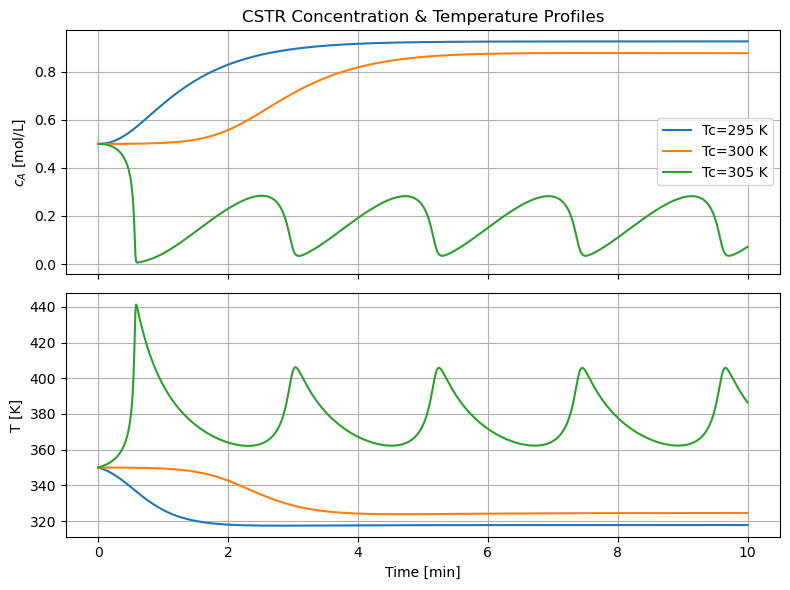

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Parameters (from reference)
Ea  = 72750.0       # J/mol
R   = 8.314         # J/mol/K
k0  = 7.2e10        # 1/min
V   = 100.0         # L
rho = 1000.0        # g/L
Cp  = 0.239         # J/g/K
dHr = -5.0e4        # J/mol (exothermic)
UA  = 5.0e4         # J/min/K
q   = 100.0         # L/min
cAf = 1.0          # mol/L
Tf  = 350.0         # K

# Initial conditions
cA0 = 0.5           # mol/L
T0  = 350.0         # K

# Time grid (minutes)
t_final = 10.0
t_eval = np.linspace(0.0, t_final, 1000)

# Arrhenius rate constant, k(T) [1/min]
def k_of_T(T):
    return k0 * np.exp(-Ea / (R * T))

# ODEs for [cA, T]
def cstr_odes(t, y, Tc):
    cA, T = y
    k = k_of_T(T)
    dcAdt = (q/V) * (cAf - cA) - k * cA
    dTdt  = (q/V) * (Tf - T) + (-dHr/(rho*Cp)) * k * cA + (UA/(V*rho*Cp)) * (Tc - T)
    return [dcAdt, dTdt]


# Time profiles for multiple cooling temperatures
Tcs = [295.0, 300.0, 305.0]  # K

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)


for Tc in Tcs:
    sol = solve_ivp(
        
        # Let's use a lambda function here :)
        fun = lambda t, y: cstr_odes(t, y, Tc),
        t_span=(t_eval[0], t_eval[-1]),
        y0=[cA0, T0],
        t_eval=t_eval,
        rtol=1e-8, atol=1e-10,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    
    ax1.plot(sol.t, sol.y[0], label=f"Tc={Tc:.0f} K")
    ax2.plot(sol.t, sol.y[1], label=f"Tc={Tc:.0f} K")

ax1.set_ylabel("$c_A$ [mol/L]")
ax1.set_title("CSTR Concentration & Temperature Profiles")
ax1.grid(True)
ax1.legend()

ax2.set_xlabel("Time [min]")
ax2.set_ylabel("T [K]")
ax2.grid(True)

fig1.tight_layout()



## Nullclines and Phase-Plane Analysis

To better understand the nonlinear dynamics of the exothermic CSTR, it is useful to examine the **nullclines** of the system.  

- The **concentration nullcline** is defined by the set of points where  

$$
\frac{dc_A}{dt} = 0 \quad \Rightarrow \quad 
c_A = \frac{\tfrac{q}{V} \, c_{A,f}}{\tfrac{q}{V} + k(T)}
$$

- The **temperature nullcline** is defined by the set of points where  

$$
\frac{dT}{dt} = 0 \quad \Rightarrow \quad 
c_A = \frac{\rho q C_p (T_f - T) + UA(T_c - T)}{V \, \Delta H_R \, k(T)}
$$

The intersections of these two curves in the $(c_A, T)$ phase plane correspond to **steady-state operating points** of the reactor. Because the reaction is highly exothermic, multiple intersections (steady states) can occur.  

By plotting the nullclines together with a sample **trajectory** (solution of the differential equations for given initial conditions), we can visualize how the system state evolves over time and towards which steady state it converges.  

This approach provides valuable insight into reactor stability and helps explain phenomena such as **thermal runaway** or **multiple steady-state behavior** in CSTRs.  


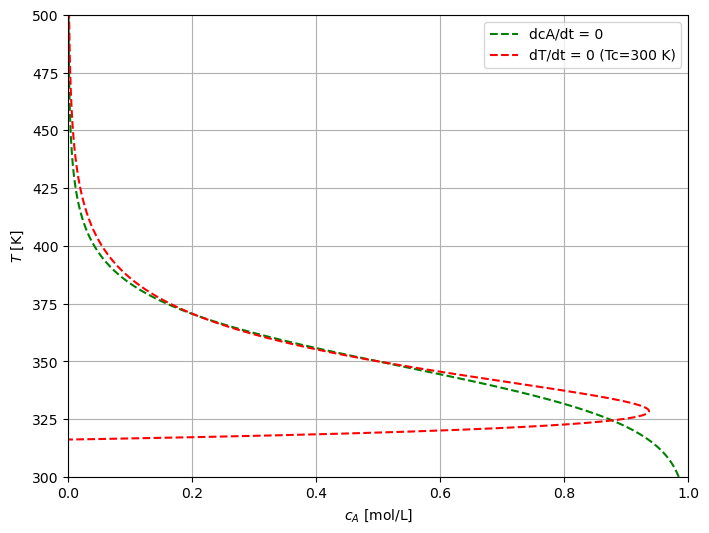

In [2]:
def k(T):
    return k0 * np.exp(-Ea / (R * T))

def plot_nullclines(ax, Tc=300.0):
    T = np.linspace(300.0, 500.0, 1000)
    c_dc0 = (q / V) * cAf / ((q / V) + k(T))                                   # dcA/dt = 0
    c_dT0 = (rho * q * Cp * (Tf - T) + UA * (Tc - T)) / (V * dHr * k(T))       # dT/dt = 0

    ax.plot(c_dc0, T, 'g--', label=r'dcA/dt = 0')
    ax.plot(c_dT0, T, 'r--', label=fr'dT/dt = 0 (Tc={Tc:.0f} K)')
    ax.set_xlim(0.0, cAf)
    ax.set_ylim(300.0, 500.0)
    ax.set_xlabel(r'$c_A$ [mol/L]')
    ax.set_ylabel(r'$T$ [K]')
    ax.grid(True)
    ax.legend()

# Let's plot this :)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_nullclines(ax, Tc=300.0)   
plt.show()


This shows the steady-states of the CSTR for several operating points! Let's change this to 295K and 305K.

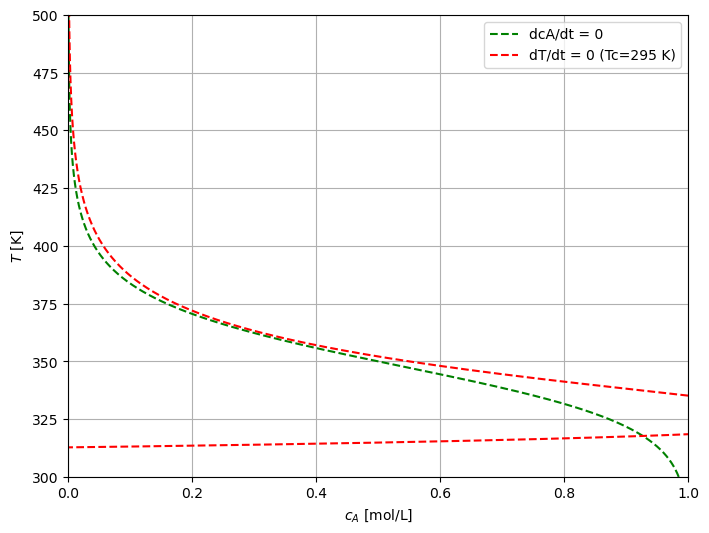

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_nullclines(ax, Tc=295.0)   
plt.show()

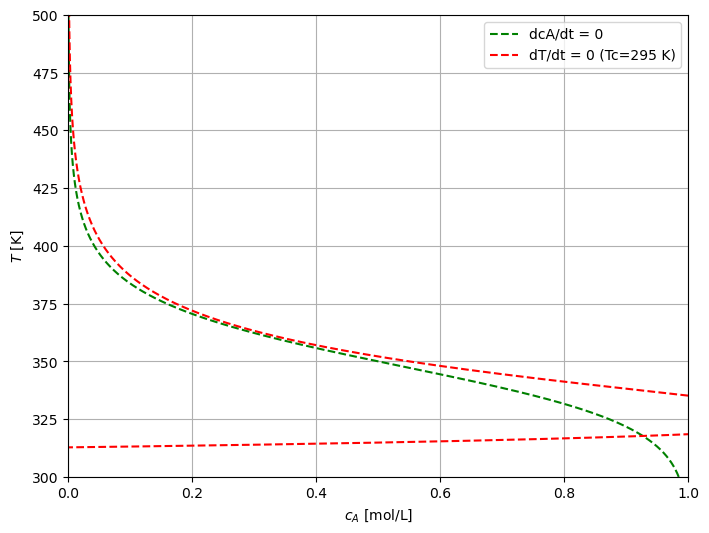

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_nullclines(ax, Tc=295.0)   
plt.show()

## A more convoluted example: A membrane reactor
[(based on my own PhD work on process operability analysis](https://codes-group.github.io/opyrability/examples_gallery/membrane_reactor.html)

This case study consists of a membrane reactor for direct methane aromatization (DMA-MR)
that allows hydrogen and benzene production from natural gas. This single-unit operation is capable of performing reaction and separation simultaneously, allowing for achieving
higher conversion of hydrogen due to Le'Chatelier's principle.

The DMA-MR model has been extensively studied in process operability analysis due to
its particular potential for system modularization and process intensification, as well as
the challenging modeling due to its inherent nonlinearity.

The schematic below depicts the membrane reactor in a nutshell: 

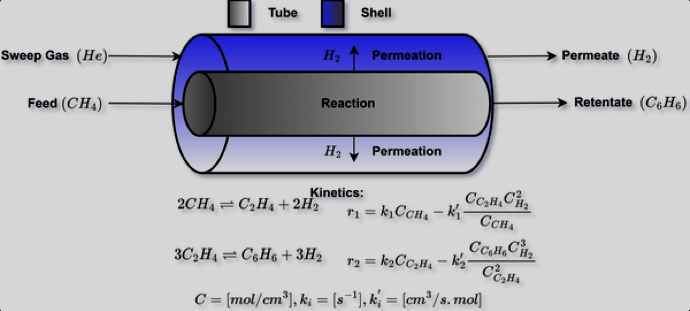

For the tube side in which the reaction takes place:


$$ 
\begin{gathered}
    \frac{d F_{t, C H_4}}{d z}= \eta \, r_1 A_t-\frac{Q}{\alpha_{H_2 / C H_4}}\left(P_{t, C H_4}^{1 / 4}-P_{s, C H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, C_2 H_4}}{d z}=-\eta\,\frac{r_1}{2} A_t+\eta \, r_2 A_t-\frac{Q}{\alpha_{H_2 / C_2 H_4}}\left(P_{t, C_2 H_4}^{1 / 4}-P_{s, C_2 H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, H_2}}{d z}=-\eta \, r_1 A_t- \eta \, r_2 A_t-Q\left(P_{t, H_2}^{1 / 4}-P_{s, H_2}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, C_6 H_6}}{d z}=-\eta \, \frac{r_1}{3} A_t-\frac{Q}{\alpha_{H_2 / C_6 H_6}}\left(P_{t, C_6 H_6}^{1 / 4}-P_{s, C_6 H_6}^{1 / 4}\right) \pi D_t
    \end{gathered}
$$

And for the shell side, in which mainly $H_{2}$ permeates to:


$$
\begin{gathered}
    \frac{d F_{s, C H_4}}{d z}=\frac{Q}{\alpha_{H_2 / C H_4}}\left(P_{t, C H_4}^{1 / 4}-P_{s, C H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, C_2 H_4}}{d z}=\frac{Q}{\alpha_{H_2 / C_2 H_4}}\left(P_{t, C_2 H_4}^{1 / 4}-P_{s, C_2 H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, H_2}}{d z}=Q\left(P_{t, H_2}^{1 / 4}-P_{s, H_2}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, C_6 H_6}}{d z}=\frac{Q}{\alpha_{H_2 / C_6 H_6}}\left(P_{t, C_6 H_6}^{1 / 4}-P_{s, C_6 H_6}^{1 / 4}\right) \pi D_t
    \end{gathered}
$$

Let's try to see if we can inspect how much the flowrates affect Benzene production and Methane conversion.

In [5]:
import numpy as np
from numpy import pi as pi
from scipy.integrate import solve_ivp

In [6]:
# Kinetic and general parameters

R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

    
# Molecular weights
MM_B = 78.00     #[g/mol] 

# Fixed Reactor Values
T = 1173.15                 # Temperature[K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flowrate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flowrate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flowrate[cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flowrate [mol/h]

Let's write down one function that perfroms the mol balances of this membrane reactor:


In [7]:
def dma_mr_model(z, F, dt, v_He, v0, F_He, Ft0):
    At = 0.25 * np.pi * (dt ** 2)  # [cm^2]

    # Avoid negatives
    F = np.where(F <= 1e-9, 1e-9, F)

    # Total flows in tube & shell
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v  = v0 * (Ft / Ft0)

    # Concentrations [mol/cm^3]
    C = F[:4] / v

    # Partial “pressures”
    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)

    # Rates
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2]**2) / (k1 * (C[0])**2)))
    r0 = np.where(C[0] <= 1e-9, 0, r0)

    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2]**3) / (k2 * (C[1])**3)))
    r1 = np.where(C[1] <= 1e-9, 0, r1)

    # Adjustments
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Balances
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t**0.25) - (P0s**0.25)) * np.pi * dt
    dF1 =  0.5 * Cat * r0 * At - Cat * r1 * At - (Q / selec) * ((P1t**0.25) - (P1s**0.25)) * np.pi * dt
    dF2 =  Cat * r0 * At + Cat * r1 * At - (Q) * ((P2t**0.25) - (P2s**0.25)) * np.pi * dt
    dF3 = (1/3) * Cat * r1 * At - (Q / selec) * ((P3t**0.25) - (P3s**0.25)) * np.pi * dt
    dF4 = (Q / selec) * ((P0t**0.25) - (P0s**0.25)) * np.pi * dt
    dF5 = (Q / selec) * ((P1t**0.25) - (P1s**0.25)) * np.pi * dt
    dF6 = (Q) * ((P2t**0.25) - (P2s**0.25)) * np.pi * dt
    dF7 = (Q / selec) * ((P3t**0.25) - (P3s**0.25)) * np.pi * dt

    return np.array([dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7])

And a function that uses the mol balances above to calculate the benzene production and methane conversion.

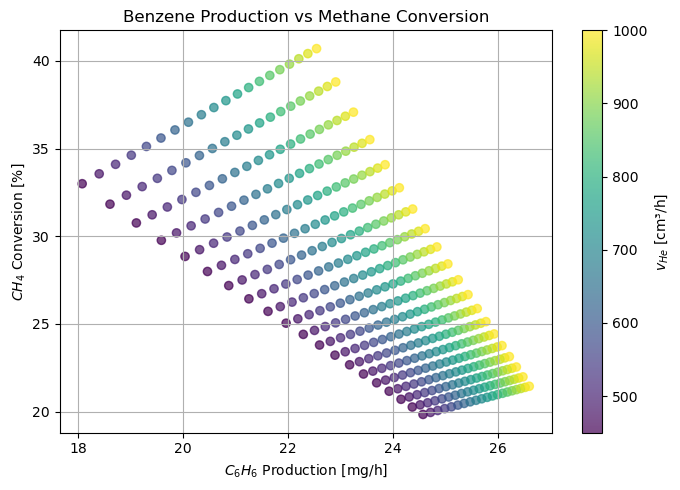

In [8]:
def dma_mr_mvs(u):
    v0, v_He = u

    # Fixed design variables:
    L  = 17.00    # [cm]
    dt = 0.55     # [cm]

    Ft0  = Pt * v0 / (R * T)      # [mol/h] – Pure CH4
    F_He = Ps * v_He / (R * T)    # [mol/h] – Sweep gas

    # Initial conditions and integrator tolerance.
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances
    z_eval = np.linspace(0.0, L, 2000)
    sol = solve_ivp(
        dma_mr_model,
        t_span=(0.0, L),
        y0=y0,
        args=(dt, v_He, v0, F_He, Ft0),
        t_eval=z_eval,
        rtol=rtol,
        atol=atol
    )
    if not sol.success:
        raise RuntimeError(f"IVP failed: {sol.message}")

    F_end = sol.y[:, -1]  # final molar flows (tube 0–3, shell 4–7)

    # Outputs
    F_C6H6 = ((F_end[3] * 1000) * MM_B)    
    X_CH4  = (100 * (Ft0 - F_end[0] - F_end[4]) / Ft0)

    return np.array([F_C6H6, X_CH4])



# Empty lists (preallocation)
F_C6H6_vals = []
X_CH4_vals  = []
v0_list     = []
vHe_list    = []

# Solving for all flowrates :)
for v0 in np.linspace(450, 1000, 20):
    for v_He in np.linspace(450, 1000, 20):
        F_C6H6, X_CH4 = dma_mr_mvs([v0, v_He])
        F_C6H6_vals.append(F_C6H6)
        X_CH4_vals.append(X_CH4)
        v0_list.append(v0)
        vHe_list.append(v_He)

# Scatter of F_C6H6 vs X_CH4 (color-coded by v_He to add context)
plt.figure(figsize=(7,5))
sc = plt.scatter(F_C6H6_vals, X_CH4_vals, c=vHe_list, alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label("$v_{He}$ [cm³/h]")
plt.xlabel("$C_6H_6$ Production [mg/h]")
plt.ylabel("$CH_4$ Conversion [%]")

plt.title("Benzene Production vs Methane Conversion")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot above corresponds to the **operable** region of this membrane reactor. In short, it can only generate Benzene and convert natural gas ($CH_4$) within this interesting shape. Any other combination of conversion and production is not viable, with the values of flowrates and parameters we have set!

#  Chaos!

## Background
In the 60s, Edward Lorenz, a meteorologist at MIT, discovered that a simple set of nonlinear equations describing atmospheric convection could produce highly irregular, unpredictable behavior. His work gave rise to **chaos theory** and the famous concept of the **butterfly effect** — the idea that tiny changes in initial conditions can grow into vastly different outcomes.

See more details [here](https://www.aps.org/archives/publications/apsnews/200301/history.cfm) and [here](https://en.wikipedia.org/wiki/Edward_Norton_Lorenz)

## The Lorenz Equations
The Lorenz system is a set of three coupled, nonlinear ordinary differential equations:

$$
\frac{dx}{dt} = \sigma (y - x)
$$

$$
\frac{dy}{dt} = x(\rho - z) - y
$$

$$
\frac{dz}{dt} = xy - \beta z
$$

where:
- $x$ represents convection,
- $y$ represents horizontal temperature variation,
- $z$ represents vertical temperature variation,
- $\sigma$, $\rho$, and $\beta$ are positive parameters. They are, actually, related to the [Prandtl number](https://en.wikipedia.org/wiki/Prandtl_number) and the [Rayleigh](https://en.wikipedia.org/wiki/Rayleigh_number)

For certain parameter values, these equations generate the **Lorenz attractor**, a structure with a distinctive *butterfly* shape in 3D phase space.

## Importance
- **Chaos and Determinism**: The Lorenz system showed for the first time that deterministic equations (no randomness) can yield unpredictable, chaotic dynamics.  
- **Sensitivity to Initial Conditions**: Two trajectories starting almost identically diverge exponentially, making long-term prediction impossible.  
- **Applications**: Beyond weather, chaotic dynamics appear in fluid flows, chemical reactors, lasers, circuits, and even biological systems.  

### What We Do Here
1. We simulate the Lorenz system for standard chaotic parameters $ \sigma=10, \ \rho=35, \ \beta=8/3 $.
2. We launch two trajectories with nearly identical initial conditions $ \Delta = 10^{-3} $.
3. We visualize:
   - The 3D phase space evolution, showing the iconic butterfly attractor.
   - The growth of the separation $ \|\Delta \mathbf{s}(t)\| $ between trajectories, plotted on a logarithmic scale to highlight exponential divergence.



This animated example shows the essence of chaos: **deterministic dynamics that are highly sensitive, complex, and unpredictable**.

IntSlider(value=0, description='evolution', layout=Layout(width='700px'), max=3000)

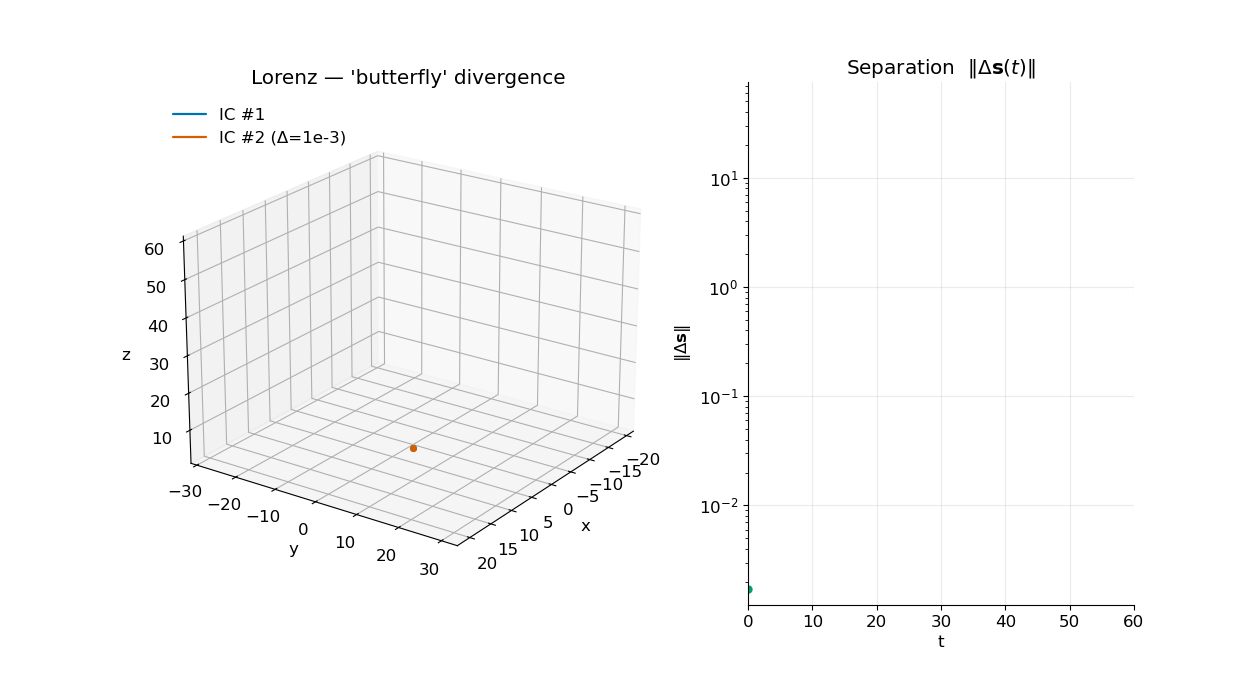

In [10]:
# Requirement (recommended): !pip install ipympl

import numpy as np
import matplotlib as mpl
import ipympl 


import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
from IPython.display import display

# Let's Generate trajectories (two close Initial Conditions)
sigma, rho, beta = 10.0, 35.0, 8.0/3.0


def lorenz(t, state):
    # "state" is the state vector [x, y, z]
    x, y, z = state
    return [sigma*(y - x),
            x*(rho - z) - y,
            x*y - beta*z]

# Dense trajectory (enough for smooth curves) but not insanely large. :)
t_eval = np.linspace(0, 60, 24001)    # ~0.005 step
y0      = [1.0, 1.0, 1.0]
y0_pert = [1.0 + 1e-3, 1.0 + 1e-3, 1.0 + 1e-3]    # visible divergence

# Solve both trajectories
sol1 = solve_ivp(lorenz, (0, t_eval[-1]), y0,      t_eval=t_eval, rtol=1e-9, atol=1e-12)
sol2 = solve_ivp(lorenz, (0, t_eval[-1]), y0_pert, t_eval=t_eval, rtol=1e-9, atol=1e-12)

t  = sol1.t
X1, Y1, Z1 = sol1.y
X2, Y2, Z2 = sol2.y
delta = np.linalg.norm(sol1.y - sol2.y, axis=0)

# Drawing samples for animation. 1500-3000 is ok.
target_frames = 3000
step = max(1, len(t) // target_frames)
idx = np.arange(0, len(t), step)
t_a   = t[idx]
X1a, Y1a, Z1a = X1[idx], Y1[idx], Z1[idx]
X2a, Y2a, Z2a = X2[idx], Y2[idx], Z2[idx]
delta_a       = delta[idx]

# Figure, axes, and persistent artists
plt.ioff()  # we control drawing manually

c1, c2, c3 = "#0072B2", "#D55E00", "#009E73"  # colorblind-friendly
mpl.rcParams.update({
    "figure.figsize": (12.6, 6.8),
    "axes.grid": True, "grid.alpha": 0.25,
    "axes.spines.top": False, "axes.spines.right": False,
    "font.size": 12,
})

fig = plt.figure()
gs  = fig.add_gridspec(1, 2, width_ratios=[1.3, 1.0])

ax3d = fig.add_subplot(gs[0,0], projection="3d")
ax2d = fig.add_subplot(gs[0,1])

# Limits fixed once (stable axes)
ax3d.set_xlim(min(X1a.min(), X2a.min()), max(X1a.max(), X2a.max()))
ax3d.set_ylim(min(Y1a.min(), Y2a.min()), max(Y1a.max(), Y2a.max()))
ax3d.set_zlim(min(Z1a.min(), Z2a.min()), max(Z1a.max(), Z2a.max()))
ax3d.set_xlabel("x"); ax3d.set_ylabel("y"); ax3d.set_zlabel("z")
ax3d.view_init(elev=22, azim=35)
ax3d.set_title("Lorenz — 'butterfly' divergence")

(line1,) = ax3d.plot([], [], [], color=c1, lw=1.6, solid_capstyle="round", antialiased=True, label="IC #1")
(line2,) = ax3d.plot([], [], [], color=c2, lw=1.6, solid_capstyle="round", antialiased=True, label="IC #2 (Δ=1e-3)")
(dot1,)  = ax3d.plot([], [], [], "o", color=c1, ms=4)
(dot2,)  = ax3d.plot([], [], [], "o", color=c2, ms=4)
ax3d.legend(loc="upper left", frameon=False)

ax2d.set_title(r"Separation  $\|\Delta \mathbf{s}(t)\|$")
ax2d.set_xlabel("t"); ax2d.set_ylabel(r"$\|\Delta \mathbf{s}\|$")
ax2d.set_yscale("log")
ax2d.set_xlim(t_a.min(), t_a.max())
ax2d.set_ylim(max(delta_a.min(), 1e-12), delta_a.max()*1.15)
sep_line, = ax2d.plot([], [], color=c3, lw=2.0, antialiased=True)
sep_dot,  = ax2d.plot([], [], "o", color=c3, ms=5)

plt.ion(); fig.canvas.draw()

#  Slider that updates the figure.
slider = widgets.IntSlider(
    value=0, min=0, max=len(t_a)-1, step=1,
    description='evolution', continuous_update=True,
    layout=widgets.Layout(width='700px')
)

def update(i):
    # 3D trajectories up to i (smooth lines)
    line1.set_data_3d(X1a[:i+1], Y1a[:i+1], Z1a[:i+1])
    line2.set_data_3d(X2a[:i+1], Y2a[:i+1], Z2a[:i+1])
    dot1.set_data_3d(X1a[i:i+1], Y1a[i:i+1], Z1a[i:i+1])
    dot2.set_data_3d(X2a[i:i+1], Y2a[i:i+1], Z2a[i:i+1])

    # Separation trace
    sep_line.set_data(t_a[:i+1], delta_a[:i+1])
    sep_dot.set_data(t_a[i:i+1], delta_a[i:i+1])

    fig.canvas.draw_idle()

def on_change(change):
    if change["name"] == "value":
        update(change["new"])

slider.observe(on_change)

display(slider)
update(slider.value) 
plt.show()

## Wait, why do we, as chemical engineers, care?


It turns out that chaos and multiplicity of steady states also heavily affect chemical systems. Additionally, a topic closely related to chaos is bifurcation theory.

For example, let's take a look at [this paper](https://www.sciencedirect.com/science/article/pii/S0263876219302928)

## Let's recap...

1. ODE systems might not be analytically tractable. We need numerical methods to approximate the solution!
2. ODEs are ubiquitous in science. It is a core modeling approach for many chemical engineering systems.
3. Multiple steady states, chaos, bifurcations and other weird phenomena are not uncommon in chemical engineering applications. However, we know which set of tools/theory we must employ in order to circumvent these challenges :)


##  Practice problems you might get asked in your HW...

- Derive Euler from TSE; implement and test on a known solution; study step-size effects.
- Use `solve_ivp` with `events` to detect and stop at thresholds (e.g., safety limits in a chemical reactor).
- Model a forced system (e.g., CSTR) with time-dependent inputs.
- **Model systems of ODEs in general using scipy's solve_ivp**


In the next class, we will begin covering ML. This class ends the first half of this course!